### Classify the titles of the podcasts as relevant to be summarize or not.

- 1. Labelize podcast dataset using guest and manual labelling.
- 2. Augment podcast dataset using back translation.
- 3. Fine-tune distil bert model classifier.
- 4. Analyse performances and dump champion classifier.

In [228]:
%load_ext autoreload
%autoreload 2

import requests
import os
import joblib
import math
from copy import deepcopy
import multiprocessing as mp
from functools import partial
from html import unescape
from unidecode import unidecode
from typing import Sequence, Union, Tuple, Dict
from tqdm import tqdm

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)

import torch
from bs4 import BeautifulSoup
import translators as ts
from transformers import (
    BertTokenizer, BertForSequenceClassification, DistilBertTokenizer,
    DistilBertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
)
from transformers.tokenization_utils_base import (
    BatchEncoding, PreTrainedTokenizerBase
)
from datasets import Dataset, load_metric
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from podconcise.scraping import (
    parse_podcats
)
from podconcise.nlp_utils import (
    hash_str, augment_with_backtranslation,
    tokenize_title, compute_classification_metrics,
)
from podconcise.constant import (
    DATA_SCIENCE_GUESTS
)
from podconcise.plot_utils import plot_learning_curve

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/pierre/project/PodConcise/podconcise/plot_utils.py:6: SyntaxWarning: invalid escape sequence '\ '
  """


In [185]:
!pip install matplotlib

  Using cached matplotlib-3.9.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached contourpy-1.2.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.53.1-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (162 kB)
  Using cached kiwisolver-1.4.5-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.4 kB)
  Using cached pillow-10.4.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (9.2 kB)
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
Using cached matplotlib-3.9.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.3 MB)
Using cached contourpy-1.2.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (309 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.53.1-cp312-cp312-manylinux_2_5_x86_64.m

In [2]:
url_podcasts = "https://lexfridman.com/podcast"

PATH_DATA = r"../data"
PATH_MODEL = r"../model"
PATH_LOG = r"../log"
PATH_TRAINING = r"../training"

FILE_PODCAST = r"podcast.csv"
FILE_PODCAST_AUGMENTED = r"podcast_augmented.csv"

MODEL_DBERT_TOPIC_CLASSIFIER = r"distil_bert_topic_to_summarize"
MODEL_DBERT_TOPIC_CLASSIFIER_AUGMENTED = r"distil_bert_topic_to_summarize_augmented"

LABELS = ['to_pass', 'to_summarize']

loading checkpoints

In [3]:
file = os.path.join(PATH_DATA, FILE_PODCAST)
df_podcast = pd.read_csv(file, sep=";")
print(df_podcast.shape)

file = os.path.join(PATH_DATA, FILE_PODCAST_AUGMENTED)
df_pod_augmented = pd.read_csv(file, sep=";")
df_pod_augmented.shape

(436, 8)


(1560, 9)

##### Retrieving of the podcasts.

In [7]:
res = requests.get(url_podcasts)
html_content = res.content
soup_podcasts = BeautifulSoup(html_content, 'html.parser')
    
podcasts = parse_podcats(soup_podcasts)
titles = [p.title for p in podcasts]

##### First attempt at classifying the podcasts based on their title using a pre-trained NOT fine-tuned model.

In [8]:
model_name = "bert-base-uncased" 
# model_name = "distilbert-base-uncased" 

tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
for title in titles[:10]:

    inputs = tokenizer(
        title,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=512
    )
    outputs = model(**inputs) 
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()

    label = LABELS[predicted_class]

    print(f'{title}\n{label}')

Survival, Hunting, Siberia, God, and Winning Alone Season 6
related to AI
Politics, Family, Real Estate, Fashion, Music, and Life
related to AI
Focus, Controversy, Politics, and Relationships
related to AI
Perplexity CEO on Future of AI, Search & the Internet
related to AI
Physics of Life, Time, Complexity, and Aliens
related to AI
Power, Controversy, Betrayal, Truth & Love in Film and Life
related to AI
Dangers of Superintelligent AI
not related to AI
Human Memory, Imagination, Deja Vu, and False Memories
related to AI
Jungle, Apex Predators, Aliens, Uncontacted Tribes, and God
not related to AI
General Relativity, Quantum Mechanics, Black Holes & Aliens
related to AI


**Plan of action:**

- Fine-tune distilled Bert.
    - create a training set.
        - Use guest to labellize past titles.
        - Use traduction and synonms to do data augmentation.
        - scrap some data.
    - Do the fine tuning
- Test it of a validation set.  

#### Training dataset creation

In [10]:
df_podcast = pd.DataFrame(podcasts)


cols_to_pp = ["guest", "title"]

def preprocess_podcasts(df: pd.DataFrame, cols_to_pp: Sequence[str]) -> pd.DataFrame:


for col in cols_to_pp:
    df_podcast[col] = np.vectorize(lambda title: unidecode(title))(df_podcast[col])
    df_podcast[col] = df_podcast[col].str.lower()

hash_str_vec = np.vectorize(hash_str)
df_podcast.insert(0, 'id', hash_str_vec(df_podcast.guest + df_podcast.title))

assert df_podcast.id.nunique() == len(df_podcast), "colision in the hashing to create unique id!"

The positive titles will be:
- titles of podcast whose guest is a AI/ML/DS person I am interested in.

or

- titles with ML terms that I will validate by hand.

In [ ]:
words_to_check = [
    "Neural Nets",
    "neural networks",
    "Deep Learning",
    "Machine learning",
    "Reinforcement Learning",
    "Data science",
    "AI",
    "AGI",
    "artificial intelligence"
]
words_to_check_pp = [unidecode(word).lower() for word in words_to_check]

Manual validation based on regex.

In [12]:
def is_guest_relevant(guest_candidate: str, data_science_guests: Sequence[str]) -> bool:
    """
    Check if any data science guest is contained in the given guest_candidate.
    Necessary because some guest_candidate contained multiple guests.
    """
    return any(relevant_guest in guest_candidate for relevant_guest in data_science_guests)

is_guest_relevant_vec = np.vectorize(
    is_guest_relevant,
    excluded=['data_science_guests'],
    signature='(),(n)->()'
)

data_science_guests_pp = [unidecode(guest).lower() for guest in DATA_SCIENCE_GUESTS]
df_podcast["has_relevant_guest"] = is_guest_relevant_vec(df_podcast.guest, data_science_guests_pp).astype(int)

re_not_character_or_beginning = r'(?:[^a-z]|^)'
re_not_character_or_end = r'(?:[^a-z]|$)'

pattern = (
    re_not_character_or_beginning +
    (f'{re_not_character_or_end}|{re_not_character_or_beginning}').join(words_to_check_pp) + 
    re_not_character_or_end
)
df_podcast["has_ml_word"] = df_podcast.title.str.contains(pattern, case=False, regex=True).astype(int)

In [13]:
batch = 0
increment = 9

df_to_check = df_podcast.loc[
    (df_podcast.has_relevant_guest == 0) & (df_podcast.has_ml_word == 1) 
]

for _, (id, guest, title) in df_to_check.loc[:,["id", "guest", "title"]].iloc[batch*increment: batch*increment + increment].iterrows():
    print(f"{id}: {guest}\n{title}\n")

98195452: roman yampolskiy
dangers of superintelligent ai

86440844: guillaume verdon
beff jezos, e/acc movement, physics, computation & agi

68071720: elon musk
war, ai, aliens, politics, physics, video games, and humanity

65917750: george hotz
tiny corp, twitter, ai safety, self-driving, gpt, agi & god

60879511: marc andreessen
future of the internet, technology, and ai

99072863: mark zuckerberg
future of ai at meta, facebook, instagram, and whatsapp

41763735: chris lattner
future of programming and ai

68276965: manolis kellis
evolution of human civilization and superintelligent ai

62663336: eliezer yudkowsky
dangers of ai and the end of human civilization



In [14]:
manual_positive_id = [
    98195452,
    41763735,
    68276965,
    59789751,
    60449962,
    93271390,
    79695739,
    31945141,
    58779362,
]

df_podcast["manual_label"] = df_podcast.id.isin(manual_positive_id).astype(int)

df_podcast["label"] = (
    df_podcast.manual_label | df_podcast.has_relevant_guest
).astype(int)

save = False
if save:
    file = os.path.join(PATH_DATA, FILE_PODCAST)
    df_podcast.to_csv(file, sep=";", index=False)

In [15]:
df_podcast.sample(10)

,id,guest,title,url_transcript,has_relevant_guest,has_ml_word,manual_label,label
392,70048196,david ferrucci,"ibm watson, jeopardy & deep conversations with ai",None,0,1,0,0
125,84886709,duncan trussell,"comedy, sentient robots, suffering, love & bur...",None,0,0,0,0
422,65723187,kyle vogt,cruise automation,None,0,0,0,0
255,61908201,john danaher,"the path to mastery in jiu jitsu, grappling, j...",None,0,0,0,0
38,87017009,jared kushner,"israel, palestine, hamas, gaza, iran, and the ...",https://lexfridman.com/jared-kushner-transcript,0,0,0,0
331,83445856,matt botvinick,"neuroscience, psychology, and ai at deepmind",None,1,1,0,1
54,99072863,mark zuckerberg,"future of ai at meta, facebook, instagram, and...",None,0,1,0,0
73,81641693,chris voss,fbi hostage negotiator,None,0,0,0,0
251,86922028,bryan johnson,kernel brain-computer interfaces,None,0,0,0,0
337,63726207,karl friston,neuroscience and the free energy principle,None,0,0,0,0


#### Data augmentation

##### Using synonyms

In [16]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.corpus import wordnet as wn


[nltk_data] Downloading package wordnet to /home/pierre/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/pierre/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
def get_synonyms(word):
    synonyms = set()
    for syn in wn.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    if word in synonyms:
        synonyms.remove(word)
    return list(synonyms)

get_synonyms('car')

['railroad_car',
 'gondola',
 'cable_car',
 'railway_car',
 'railcar',
 'motorcar',
 'automobile',
 'machine',
 'elevator_car',
 'auto']

=> too noisy, maybe in conjonction with post-tagging but that would be too much work for that project.

##### Using back translation

In [18]:
print(ts.translators_pool)

['alibaba', 'apertium', 'argos', 'baidu', 'bing', 'caiyun', 'cloudTranslation', 'deepl', 'elia', 'google', 'hujiang', 'iciba', 'iflytek', 'iflyrec', 'itranslate', 'judic', 'languageWire', 'lingvanex', 'niutrans', 'mglip', 'mirai', 'modernMt', 'myMemory', 'papago', 'qqFanyi', 'qqTranSmart', 'reverso', 'sogou', 'sysTran', 'tilde', 'translateCom', 'translateMe', 'utibet', 'volcEngine', 'yandex', 'yeekit', 'youdao']


In [19]:
txt = "Hello mummy, you are the prettiest! I am so glad I am your son."
_translator = "google" #| "google"
intermediate_language = "fr" # "fr"

txt_translated = ts.translate_text(
    txt,
    translator=_translator,
    from_language="en",
    to_language=intermediate_language,
)

txt_back_translated = ts.translate_text(
    txt_translated,
    translator=_translator,
    from_language=intermediate_language,
    to_language="en",
)

print(txt)
print(txt_translated)
print(txt_back_translated)

Hello mummy, you are the prettiest! I am so glad I am your son.
Bonjour maman, tu es la plus jolie! Je suis tellement content d'être ton fils.
Hello mom, you are the prettiest! I'm so happy to be your son.


In [20]:
%%time

translators = [
    "google",
    # "alibaba",
]

intermediate_languages = [
    "ja", # Japenese
    "fr", # French
    "es", # Spanish
    "zh", # Chinese
    "de", # German
    "no" # Norwegian
]


augment_with_backtranslation_parametrized = partial(
    augment_with_backtranslation,
    translators=translators,
    intermediate_languages=intermediate_languages,
    return_original_text=True,
)

pool = mp.Pool(4)
res_backtranslation = list(
    tqdm(
        pool.imap(
            augment_with_backtranslation_parametrized,
            df_podcast.title.values
        ),
    total=len(df_podcast)
))
pool.close()
pool.join()

focus, controversy, politics, and relationshipssurvival, hunting, siberia, god, and winning alone season 6

politics, family, real estate, fashion, music, and lifeperplexity ceo on future of ai, search & the internet


  0%|          | 0/436 [00:00<?, ?it/s]


physics of life, time, complexity, and aliens

  0%|          | 0/436 [00:00<?, ?it/s]

power, controversy, betrayal, truth & love in film and life
dangers of superintelligent ai
human memory, imagination, deja vu, and false memories

jungle, apex predators, aliens, uncontacted tribes, and godhuman language, psycholinguistics, syntax, grammar & llmsgeneral relativity, quantum mechanics, black holes & aliensjudo, olympics, winning, losing, and the champion mindset


channel 5, gonzo, qanon, o-block, politics & alex jonesisrael-palestine, gaza, hamas, middle east, satire & fame

war, politics, and the military industrial complex
shark tank, dei & wokeism debate, elon musk, politics & drugs

ufc, fighting, khabib, conor, tyson, ali, rogan, elon & zucknuclear war, cia, kgb, aliens, area 51, roswell & secrecy

openai, gpt-5, sora, board saga, elon musk, ilya, power & agifinkelstein, destiny, m. rabbani & benny morris
the art of cooking, tesla, spacex, zip2, and family
meta ai, open source, limits of llms, agi & the future of ai
history of ukraine, russia, soviet union, kgb, na



politics, kanye, trump, biden, hitler, extremism, and wariran protests, mahsa amini, history, cia & nuclear weaponsvladimir putin and donald trumptesla ai, self-driving, optimus, aliens, and agi



how to fix government, twitter, science, and the fdakanye 'ye' west interview
social robots, ethics, privacy and the future of mit
chess, magnus, kasparov, and the psychology of greatness

grappling, jiu jitsu, adcc, and animal combathans niemann, magnus carlsen, cheating scandal & chess bots

free will, consciousness, and the nature of realitybiology, life, aliens, evolution, embryogenesis & xenobotspoker

comedy, madtv, ai, friendship, madness, and pro wrestling

singularity, superintelligence, and immortalityemotion ai, social robots, and self-driving cars
world war i, ideology, propaganda, and politicschess, streaming, and fame


origin of life, evolution, aliens, biology, and consciousnessmeaning crisis, atheism, religion & the search for wisdom

putin, ukraine, china, and nuclear war

NameError: name 'product' is not defined


javascript, firefox, mozilla, and bravestartups, angel investing, capitalism, and friendshipwallstreetbets, numerai, and the future of stock tradingthe next generation of big ideas and brave minds



comedy, power, conspiracy theories, and freedomrocket engines and electric spacecraft propulsionai and physics
aliens, black holes, and the mystery of the oumuamua


evolution of proteins, viruses, life, and ai
olympic wrestling, mental toughness & the making of championsspeech recognition with ai and humans

freedom, hope, and happiness amidst chaos
aliens, technology, religion & the nature of belief
machine learning and educationwaymo and the future of self-driving cars
rapid testing, viruses, and the engineering mindset
psychedelics

reinforcement learning and the future of aithe art of fighting and the pursuit of excellence

meaning of life, the universe, and everything
economics of ai, social networks, and technologylove, evolution, and the human brainneuroscience of optimal performa

In [ ]:
df_pod_augmented = df_podcast.copy(deep=True)

map_text_to_augmented_texts = {
    text: augmented_texts for text, augmented_texts 
    in res_backtranslation
}
df_pod_augmented["title_backtranslated"] = df_pod_augmented.title.map(map_text_to_augmented_texts)
df_pod_augmented = df_pod_augmented.explode("title_backtranslated").reset_index(drop=True)

save = False
if save:
    file = os.path.join(PATH_DATA, FILE_PODCAST_AUGMENTED)
    df_pod_augmented.to_csv(file, sep=";", index=False)
    print("Augmented podcast file saved.")

ai in the age of reason

#### Data augmentation impact on performance.

In [5]:
def augment_df_dataset(df_train: pd.DataFrame, df_pod_augmented: pd.DataFrame) -> pd.DataFrame:
    """
    Given a training datafame and a dataframe with augmented title, add all augmented titles relevant to the the training. 
    """
    df_augmented = df_pod_augmented.loc[:, ["id", "title_backtranslated", "label"]].merge(
        df_train.loc[:,['id']],
        on="id",
        how="inner",
    )
    df_dataset_augmented = df_augmented.rename(columns={"title_backtranslated": "title"}).loc[:, ["id", "title", "label"]].dropna()

    df_train_augmented = pd.concat((df_train, df_dataset_augmented), axis=0)

    return df_train_augmented

- load a pretrained Distil Bert model with its tokenizer.
- define a function to tokenize batch of the dataset and a functions to compute classification metrics (f1 and accuracy).

Note:
- A posteriori, it could be more efficient to do the data augmentation inside a map function of a dataset.
- It has been choosen not to fine-tuned the tokenizer since the corpus is not too specific and we does not to retrained our model to adapt it to the new vocabulary.

In [8]:
model_name = "distilbert-base-uncased" # "bert-base-uncased" 

tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
if True:
    raise Exception("Are you sure to want to reset dataset split?")

df_dataset = df_podcast.loc[:, ["id", "title", "label"]]

df_train, df_test = train_test_split(
    df_dataset,
    test_size=.35,
    stratify=df_podcast.label,
    random_state=20
)
df_train_augmented = augment_df_dataset(df_train, df_pod_augmented)
# For later usages, this split is save.
dfs_and_names = (
    (df_train, df_train_augmented, df_test),
    ("df_classify_title_train", "df_classify_title_train_augmented", "df_classify_title_test")
)
for df, name in zip(*dfs_and_names):
    joblib.dump(df, os.path.join(PATH_DATA, name))

dataset_train = Dataset.from_pandas(df_train)
dataset_train = dataset_train.map(tokenize_title, batched=True)

dataset_train_augmented = Dataset.from_pandas(df_train_augmented)
dataset_train_augmented = dataset_train_augmented.map(tokenize_title, batched=True)

dataset_test = Dataset.from_pandas(df_test)
dataset_test = dataset_test.map(tokenize_title, batched=True)


Map: 100%|██████████| 153/153 [00:00<00:00, 5443.59 examples/s]


In [172]:
PATH_LOG

'../log'

In [202]:
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=1,  
    early_stopping_threshold=1.0,
)

training_args = TrainingArguments(
    output_dir=os.path.join(PATH_TRAINING, MODEL_DBERT_TOPIC_CLASSIFIER),
    logging_dir=PATH_LOG,   
    num_train_epochs=5,             
    per_device_train_batch_size=8,  
    per_device_eval_batch_size=8,   
    learning_rate=5e-5,  
    warmup_steps=50,               
    weight_decay=1e-3,              
    logging_steps=20,
    eval_steps=20,
    eval_strategy="steps",
    load_best_model_at_end=True,    
    metric_for_best_model="f1_plus_log_likelihood",# "f1"
    save_total_limit=10,
    save_strategy="steps",  
)
trainer = Trainer(
    model=deepcopy(model),
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_test,
    compute_metrics=compute_classification_metrics,
    callbacks=[early_stopping_callback],
)

training_args = TrainingArguments(
    output_dir=os.path.join(PATH_TRAINING, MODEL_DBERT_TOPIC_CLASSIFIER_AUGMENTED),
    logging_dir=PATH_LOG,   
    num_train_epochs=5,             
    per_device_train_batch_size=8,  
    per_device_eval_batch_size=8, 
    learning_rate=5e-5,  
    warmup_steps=100,               
    weight_decay=1e-3,              
    logging_steps=20,
    eval_steps=20,
    eval_strategy="steps",
    load_best_model_at_end=True,    
    metric_for_best_model="f1_plus_log_likelihood",# "f1"
    save_total_limit=10,
    save_strategy="steps",  
)
trainer_augmented = Trainer(
    model=deepcopy(model),
    args=training_args,
    train_dataset=dataset_train_augmented,
    eval_dataset=dataset_test,
    compute_metrics=compute_classification_metrics,
    callbacks=[early_stopping_callback],
)

Of course, before fine-tuning, both models have the same mediocre performancs:

In [160]:
pred_logits, pred_labels, metrics = trainer.predict(dataset_test)
print(compute_classification_metrics((pred_logits, dataset_test['label'])))

pred_logits, pred_labels, metrics = trainer_augmented.predict(dataset_test)
print(compute_classification_metrics((pred_logits, dataset_test['label'])))

{'accuracy': 0.17647058823529413, 'f1': 0.2222222222222222, 'log_loss': 0.7207661217961107}


{'accuracy': 0.17647058823529413, 'f1': 0.2222222222222222, 'log_loss': 0.7207661217961107}


Training without data augmentation.

In [101]:
model.classifier.weight

Parameter containing:
tensor([[-0.0147,  0.0289,  0.0070,  ..., -0.0121,  0.0212,  0.0105],
        [ 0.0182,  0.0156, -0.0014,  ...,  0.0182,  0.0068, -0.0004]],
       requires_grad=True)

In [102]:
trainer.model.classifier.weight

Parameter containing:
tensor([[-0.0147,  0.0289,  0.0070,  ..., -0.0121,  0.0212,  0.0105],
        [ 0.0182,  0.0156, -0.0014,  ...,  0.0182,  0.0068, -0.0004]],
       requires_grad=True)

In [43]:
trainer_augmented.model.classifier.weight

Parameter containing:
tensor([[-0.0147,  0.0289,  0.0070,  ..., -0.0121,  0.0212,  0.0105],
        [ 0.0182,  0.0156, -0.0014,  ...,  0.0182,  0.0068, -0.0004]],
       requires_grad=True)

In [203]:
%%time

train_result = trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Log Likelihood,F1 Plus Log Likelihood
20,0.643300,0.492151,0.849673,0.000000,-0.492151,-0.492151
40,0.417900,0.328750,0.849673,0.000000,-0.328750,-0.328750
60,0.236900,0.354592,0.895425,0.555556,-0.354592,0.200964
80,0.185400,0.482637,0.895425,0.500000,-0.482637,0.017363
100,0.175000,0.309695,0.875817,0.641509,-0.309695,0.331815
120,0.035900,0.422938,0.908497,0.611111,-0.422938,0.188173
140,0.048200,0.433327,0.875817,0.654545,-0.433327,0.221218
160,0.005700,0.446402,0.901961,0.666667,-0.446402,0.220265
180,0.003000,0.445798,0.901961,0.666667,-0.445798,0.220868


CPU times: user 1h 24min 39s, sys: 40.3 s, total: 1h 25min 19s
Wall time: 15min 2s


In [174]:
%%time

train_result = trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Log Likelihood,F1 Plus Log Likelihood
20,0.583900,0.492151,0.849673,0.000000,-0.492151,-0.492151
40,0.381300,0.328750,0.849673,0.000000,-0.328750,-0.328750
60,0.203700,0.354592,0.895425,0.555556,-0.354592,0.200964
80,0.079900,0.482637,0.895425,0.500000,-0.482637,0.017363
100,0.127600,0.309695,0.875817,0.641509,-0.309695,0.331815
120,0.033400,0.422938,0.908497,0.611111,-0.422938,0.188173
140,0.078600,0.433327,0.875817,0.654545,-0.433327,0.221218
160,0.005900,0.446402,0.901961,0.666667,-0.446402,0.220265
180,0.002900,0.445798,0.901961,0.666667,-0.445798,0.220868


CPU times: user 1h 20min 24s, sys: 9.39 s, total: 1h 20min 34s
Wall time: 14min 5s


/home/pierre/project/PodConcise/podconcise/plot_utils.py:6: SyntaxWarning: invalid escape sequence '\ '
  """


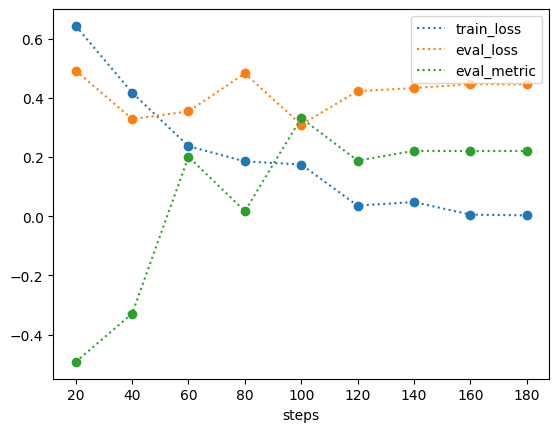

In [236]:
log_history = trainer.state.log_history
plot_learning_curve(log_history, eval_metric="eval_f1_plus_log_likelihood")

In [77]:
model.classifier.weight

Parameter containing:
tensor([[-0.0147,  0.0289,  0.0070,  ..., -0.0121,  0.0212,  0.0105],
        [ 0.0182,  0.0156, -0.0014,  ...,  0.0182,  0.0068, -0.0004]],
       requires_grad=True)

In [78]:
trainer.model.classifier.weight

Parameter containing:
tensor([[-0.0147,  0.0295,  0.0074,  ..., -0.0116,  0.0220,  0.0114],
        [ 0.0182,  0.0150, -0.0017,  ...,  0.0177,  0.0060, -0.0013]],
       requires_grad=True)

In [79]:
trainer_augmented.model.classifier.weight

Parameter containing:
tensor([[-0.0147,  0.0289,  0.0070,  ..., -0.0121,  0.0212,  0.0105],
        [ 0.0182,  0.0156, -0.0014,  ...,  0.0182,  0.0068, -0.0004]],
       requires_grad=True)

In [51]:
pred_logits, pred_labels, metrics = trainer.predict(dataset_test)
print(compute_metrics((pred_logits, dataset_test['label'])))

{'accuracy': 0.9019607843137255, 'f1': 0.6153846153846154}


In [55]:

model.save_pretrained(os.path.join(PATH_MODEL, MODEL_DBERT_TOPIC_CLASSIFIER))
tokenizer.save_pretrained(os.path.join(PATH_MODEL, MODEL_DBERT_TOPIC_CLASSIFIER))

('../model/distil_bert_topic_to_summarize/tokenizer_config.json',
 '../model/distil_bert_topic_to_summarize/special_tokens_map.json',
 '../model/distil_bert_topic_to_summarize/vocab.txt',
 '../model/distil_bert_topic_to_summarize/added_tokens.json')

Augmented training

In [80]:
%%time

train_output = trainer_augmented.train()

Step,Training Loss,Validation Loss,Accuracy,F1
20,0.672200,0.588377,0.849673,0.000000
40,0.418900,0.435002,0.849673,0.000000
60,0.484400,0.416958,0.849673,0.000000
80,0.365600,0.288530,0.869281,0.333333
100,0.241400,0.352370,0.869281,0.565217
120,0.123600,0.478247,0.856209,0.476190
140,0.336400,0.465547,0.901961,0.545455
160,0.179500,0.389250,0.869281,0.500000
180,0.058900,0.522064,0.888889,0.514286
200,0.081300,0.482673,0.882353,0.526316


CPU times: user 5h 4min 33s, sys: 2min 10s, total: 5h 6min 43s
Wall time: 1h 55min 29s


In [92]:
eval_result = trainer_augmented.evaluate()

In [82]:
model.classifier.weight

Parameter containing:
tensor([[-0.0147,  0.0289,  0.0070,  ..., -0.0121,  0.0212,  0.0105],
        [ 0.0182,  0.0156, -0.0014,  ...,  0.0182,  0.0068, -0.0004]],
       requires_grad=True)

In [83]:
trainer_augmented.model.classifier.weight

Parameter containing:
tensor([[-0.0143,  0.0296,  0.0072,  ..., -0.0125,  0.0235,  0.0117],
        [ 0.0177,  0.0149, -0.0016,  ...,  0.0186,  0.0045, -0.0016]],
       requires_grad=True)

In [84]:
pred_logits, pred_labels, metrics = trainer_augmented.predict(dataset_test)
print(compute_metrics((pred_logits, dataset_test['label'])))

{'accuracy': 0.8888888888888888, 'f1': 0.5142857142857142}


In [81]:
model_name = MODEL_DBERT_TOPIC_CLASSIFIER_AUGMENTED

model.save_pretrained(os.path.join(PATH_MODEL, model_name))
tokenizer.save_pretrained(os.path.join(PATH_MODEL, model_name))


('../model/distil_bert_topic_to_summarize_augmented/tokenizer_config.json',
 '../model/distil_bert_topic_to_summarize_augmented/special_tokens_map.json',
 '../model/distil_bert_topic_to_summarize_augmented/vocab.txt',
 '../model/distil_bert_topic_to_summarize_augmented/added_tokens.json')

_______

[anchor]
#### Usage of the model

Prediciton using a script.

In [ ]:
MODEL_DBERT_TOPIC_CLASSIFIER_AUGMENTED

In [ ]:
MODEL_DBERT_TOPIC_CLASSIFIER

In [87]:
!python ../scripts/classify_titles.py --model {MODEL_DBERT_TOPIC_CLASSIFIER_AUGMENTED} --dataset df_classify_title_test

/home/pierre/project/PodConcise/podconcise/nlp_utils.py:131: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("glue", "mrpc", trust_remote_code=True) # f1 & accuracy
100%|███████████████████████████████████████████| 20/20 [00:17<00:00,  1.15it/s]
INFO:root:Prediction done, repartition of predicted classes:
1    139
0     14
Name: count, dtype: int64
INFO:root:Prediction file dumped at: ../data/df_classify_title_predicted


Loading of the prediction dataframe.

In [88]:
file_pred = "df_classify_title_predicted"
df_pred = joblib.load(os.path.join(PATH_DATA, file_pred))
print(df_pred.shape)

(153, 4)


Local prediction

In [65]:
BATCH_SIZE = 8

df_pred = df_test.copy(deep=True)

total_preds = []
iter_dataset= dataset_test.iter(batch_size=BATCH_SIZE)

for batch in tqdm(iter_dataset, total=math.ceil(dataset_test.num_rows/BATCH_SIZE)):
    
    inputs = tokenize_title(batch, tokenizer)
    outputs = trainer.model(**inputs)
    logits = outputs.logits
    proba = torch.nn.functional.softmax(logits, dim=1)
    pred = torch.argmax(proba, dim=1).numpy()
    total_preds.append(pred)

predictions = np.concatenate(total_preds)
log_msg = (
    "Prediction done, repartition of predicted classes:\n" +
    f"{pd.Series(predictions).value_counts()}"
)
print(log_msg)
df_pred["pred"] = predictions

100%|██████████| 20/20 [00:24<00:00,  1.24s/it]

Prediction done, repartition of predicted classes:
0    137
1     16
Name: count, dtype: int64


##### Analysis of the classification errors.

In [89]:
print(classification_report(df_pred.label, df_pred.pred))

              precision    recall  f1-score   support

           0       0.64      0.07      0.12       130
           1       0.13      0.78      0.22        23

    accuracy                           0.18       153
   macro avg       0.39      0.43      0.17       153
weighted avg       0.57      0.18      0.14       153



In [90]:
df_FN =  df_pred.loc[(df_pred.pred == 0) & (df_pred.label == 1)]
df_FP =  df_pred.loc[(df_pred.pred == 1) & (df_pred.label == 0)]

print(f"False positive: {len(df_FP)},  False negative: {len(df_FN)}")

False positive: 121,  False negative: 5


In [91]:
df_FP

,id,title,label,pred
137,16037645,"comedy, controversy, aliens, and freedom",0,1
151,59793109,vladimir putin and war in ukraine,0,1
410,23331557,"the nature of the universe, life, and intellig...",0,1
194,57034767,instagram,0,1
340,42069439,going big in business,0,1
207,21939759,"war, artillery, ptsd, and love",0,1
77,46891190,"tribalism, marxism, liberalism, social justice...",0,1
158,40464880,alien debate,0,1
252,79436059,"consciousness, free will, ai, ufos, and meaning",0,1
311,36127973,"java, jvm, emacs, and the early day of computing",0,1


In [72]:
df_FN

,id,title,label,pred
414,83336465,tensorflow,1,0
18,39307966,"openai, gpt-5, sora, board saga, elon musk, il...",1,0
365,55022371,"predicates, invariants, and the essence of int...",1,0
435,29919502,life 3.0,1,0
213,81399321,"numpy, scipy, and anaconda",1,0
179,63151353,dark matter of intelligence,1,0
3,62505262,"perplexity ceo on future of ai, search & the i...",1,0
302,99900770,"computing, ai & race in america",1,0
423,39403956,"brains, minds, and machines",1,0
215,19441744,neural networks and the emergence of cognition,1,0


In [ ]:
for title in titles[:5]:

    inputs = loaded_tokenizer(title, padding=True, truncation=True, return_tensors='pt')
    outputs = loaded_model(**inputs) 
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()

    label = labels[predicted_class]

    print(f'{title}\n{label}\n')

Survival, Hunting, Siberia, God, and Winning Alone Season 6
to_pass

Politics, Family, Real Estate, Fashion, Music, and Life
to_pass

Focus, Controversy, Politics, and Relationships
to_pass

Perplexity CEO on Future of AI, Search & the Internet
to_summarize

Physics of Life, Time, Complexity, and Aliens
to_pass

Power, Controversy, Betrayal, Truth & Love in Film and Life
to_pass

Dangers of Superintelligent AI
to_summarize

Human Memory, Imagination, Deja Vu, and False Memories
to_pass

Jungle, Apex Predators, Aliens, Uncontacted Tribes, and God
to_pass

General Relativity, Quantum Mechanics, Black Holes & Aliens
to_pass

